In [31]:
# Data handling
import pandas as pd
import numpy as np
from scipy.signal.windows import gaussian, triang
# Visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Misc
import requests
import json
from datetime import datetime, timedelta

In [2]:
df = pd.read_json("data/results.json")

In [3]:
df

,url,rated,time_class,time_control,timestamp,played,rating,opponent,opponent_rating,result,info
0,https://www.chess.com/game/daily/117204770,True,daily,1/259200,2015-08-27 09:21:49,white,1296,RadioActiveRabbit,904,win,resigned
1,https://www.chess.com/game/daily/117271926,True,daily,1/86400,2015-08-28 14:14:05,black,1391,sam-marsh,1078,win,checkmated
2,https://www.chess.com/game/daily/117210408,True,daily,1/86400,2015-08-27 12:13:37,black,1417,RadioActiveRabbit,873,win,resigned
3,https://www.chess.com/game/daily/117310578,False,daily,1/86400,2015-08-29 06:21:08,white,1417,RadioActiveRabbit,873,win,resigned
4,https://www.chess.com/game/daily/117889282,False,daily,1/86400,2015-09-07 02:13:30,black,1200,RadioActiveRabbit,1000,loss,resigned
...,...,...,...,...,...,...,...,...,...,...,...
4231,https://www.chess.com/game/live/43814076047,True,rapid,600,2022-04-16 02:14:40,black,1388,Kratos10ars,1381,loss,resigned
4232,https://www.chess.com/game/live/43817050989,True,rapid,600,2022-04-16 03:04:15,white,1380,panzon23,1414,loss,resigned
4233,https://www.chess.com/game/live/43817106827,True,rapid,600,2022-04-16 03:12:49,black,1387,alanedwardoconnor,1330,win,checkmated
4234,https://www.chess.com/game/live/43827276243,True,rapid,600,2022-04-16 05:55:13,black,1379,levisarrechia4283,1415,loss,resigned


## What do I want to know?
What game styles have I played the most?
What is the break down of my wins per color?

What time of day do I play most often?
What time of day do I win most often?

What range of players do I tend to win against?

Plot the timeline of my chess score for each style of game.

## Plot the distribution of games over time using a moving average.

In [103]:
daily_games = df[["time_class", "timestamp"]].reset_index(drop=True)

daily_games["date"] = pd.to_datetime(daily_games["timestamp"].dt.date)
daily_games = daily_games[["time_class", "date", "timestamp"]].groupby(["time_class", "date"]).agg("count").reset_index()
daily_games = daily_games.rename(columns={"timestamp": "games_played"})

# Fill in the average games over empty periods of time
start_date = daily_games["date"].min()
end_date = datetime.today()
date_master = pd.DataFrame(pd.date_range(start_date, end_date), columns=["date"])

game_types = daily_games["time_class"].drop_duplicates()
master = date_master.merge(game_types, how="cross")

daily_games = master.merge(daily_games, on=["date", "time_class"], how="left")
daily_games = daily_games.fillna(0)

# Perform a rolling window average
windows = [7, 30, 60, 90] # days
for window in windows:
    weights = gaussian(window, window/(2*np.sqrt(2*np.log(10))))
    sum_weights = np.sum(weights)
    temp = daily_games.groupby('time_class')["games_played"].rolling(
        window, 
        min_periods=window, 
        center=True,
    ).apply(lambda x: np.sum(weights*x) / sum_weights, raw=False)
    daily_games[f"mean_games_{window}"] = temp.reset_index(0,drop=True)


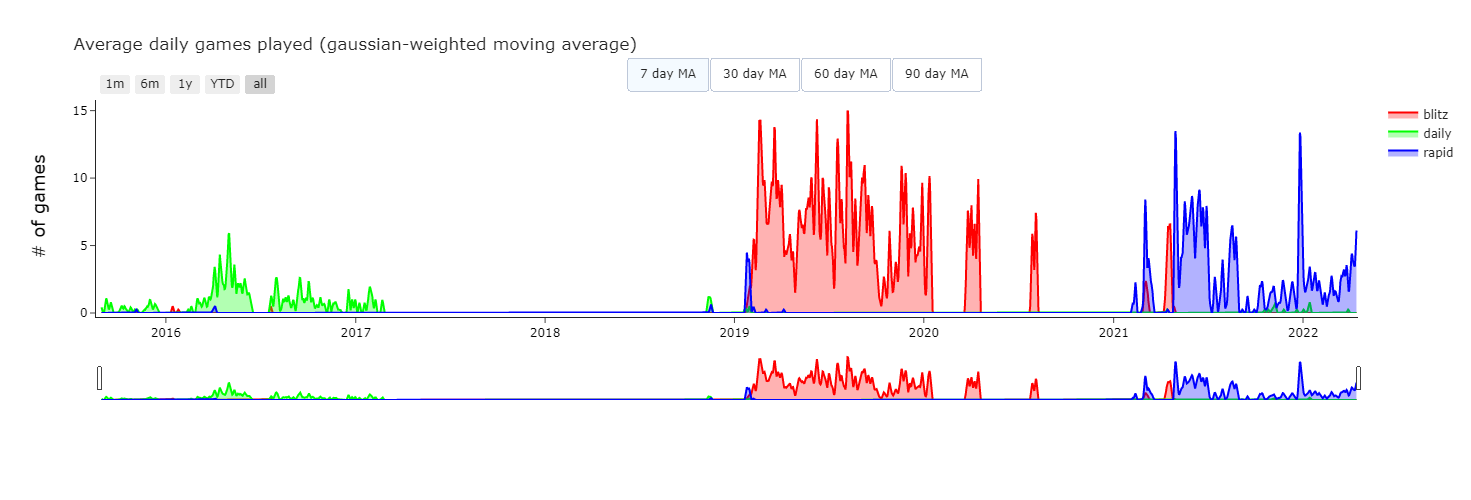

In [104]:
# Plot data
fig = go.Figure()

colors = ["rgba(255, 0, 0, %s)", "rgba(0, 255, 0, %s)", "rgba(0, 0, 255, %s)"]
button_list = []

for ww, window in enumerate(windows):
    
    for gg, game_type in enumerate(game_types.unique()):
    
        games = daily_games[(daily_games["time_class"]==game_type)]

        fig.add_trace(go.Scatter(
            x=games["date"], 
            y=games[f"mean_games_{window}"], 
            name=f"{game_type}",
            line={"color": colors[gg] % 1},
            fill='tozeroy',
            fillcolor=colors[gg] % 0.3,
            visible=True if window==7 else False
            ),
        )
        
    button = dict(
        label=f"{window} day MA",
        method="update",
        args=[
            {"visible": [False]*ww*3 + [True]*3 + [False]*(len(windows)-ww-1)*3},
        ],
    )
    button_list.append(button)

fig.update_layout(
    template="simple_white",
    title=f"Average daily games played (gaussian-weighted moving average)",
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=100,
        r=100,
        b=100,
        t=100,
        pad=4
    ),
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            x=0.7,
            y=1.2,
            showactive=True,
            buttons=button_list
        )
    ]
)

fig.update_yaxes(
    title="# of games",
    title_font=dict(size=18, color='black'), 
    tickfont=dict(color="black")
)

fig.update_xaxes(
    tickfont=dict(color="black"),
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=6, label="1y", step="year", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(step="all")
        ])
    )
)

fig.show()

## Plot distribution of games played, won, lost and drew, throughout the day

In [120]:
daily_games = df[["time_class", "timestamp", "result"]].reset_index(drop=True)
daily_games = daily_games.sort_values(by="timestamp")

# Convert to my timezone
daily_games["timestamp"] = daily_games["timestamp"].dt.tz_localize('GMT')
daily_games["timestamp"] = daily_games["timestamp"].dt.tz_convert('Australia/Perth')

# Normalise the dates
daily_games["time"] =  pd.to_datetime(daily_games["timestamp"].dt.strftime('%H:%M'), format='%H:%M')

# round the times to windows
window = 15

daily_games[f"{window}_mins"] = daily_games[f"time"].dt.round(f'{window}min')
daily_games = daily_games.groupby(["time_class", "result", f"{window}_mins"]).timestamp.count().reset_index()

daily_games = daily_games.rename(columns={"timestamp": "count"})

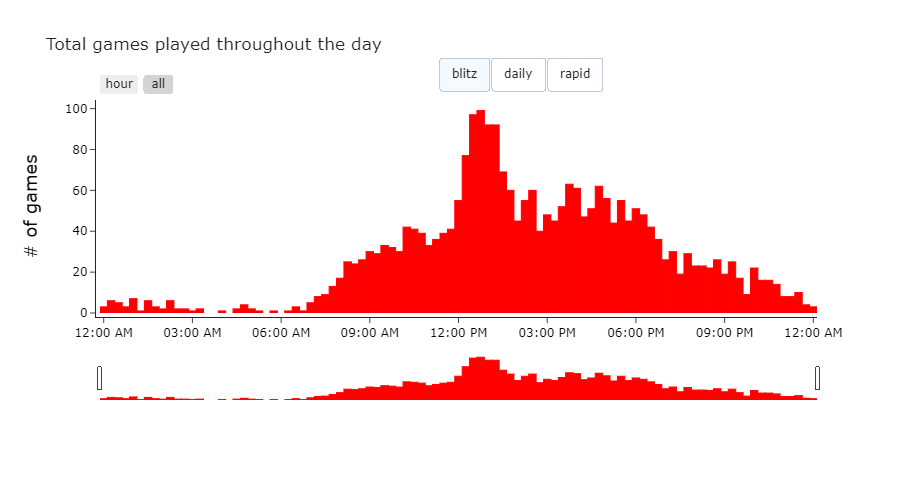

In [123]:
# Plot data
fig = go.Figure()

colors = ["rgba(255, 0, 0, %s)", "rgba(0, 200, 0, %s)", "rgba(0, 0, 255, %s)"]
button_list = []

data = daily_games[[f"{window}_mins", "time_class", "count"]].groupby([f"{window}_mins", "time_class"]).sum().reset_index()

for gg, game_type in enumerate(game_types.unique()):

    games = data[(data["time_class"]==game_type)]

    fig.add_trace(go.Bar(
        x=games[f"{window}_mins"], 
        y=games[f"count"], 
        width=window*60*1000,
        name=f"{game_type}",
        marker={
            "color": colors[gg]%1,
            "line": {"width":1, "color":colors[gg]%1}
        },
        visible=True if gg==0 else False
        ),
    )

    button = dict(
        label=game_type,
        method="update",
        args=[
            {"visible": [False]*gg + [True] + [False]*(len(game_types)-gg-1)},
        ],
    )
    button_list.append(button)

fig.update_layout(
    template="simple_white",
    title=f"Total games played throughout the day",
    xaxis_tickformat='%I:%M %p',
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=100,
        r=100,
        b=100,
        t=100,
        pad=4
    ),
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            x=0.7,
            y=1.2,
            showactive=True,
            buttons=button_list
        )
    ]
)

fig.update_yaxes(
    title="# of games",
    title_font=dict(size=18, color='black'), 
    tickfont=dict(color="black")
)

fig.update_xaxes(
    tickfont=dict(color="black"),
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="hour", step="hour", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

# Plot the percentage of wins, losses and draws throughout the day

In [131]:
daily_games = df[["time_class", "timestamp", "result"]].reset_index(drop=True)
daily_games = daily_games.sort_values(by="timestamp")

# Convert to my timezone
daily_games["timestamp"] = daily_games["timestamp"].dt.tz_localize('GMT')
daily_games["timestamp"] = daily_games["timestamp"].dt.tz_convert('Australia/Perth')

# Normalise the dates
daily_games["time"] =  pd.to_datetime(daily_games["timestamp"].dt.strftime('%H:%M'), format='%H:%M')

# round the times to windows
window = 60

daily_games[f"{window}_mins"] = daily_games[f"time"].dt.round(f'{window}min')
daily_games = daily_games.groupby(["time_class", "result", f"{window}_mins"]).timestamp.count().reset_index()

daily_games = daily_games.rename(columns={"timestamp": "count"})

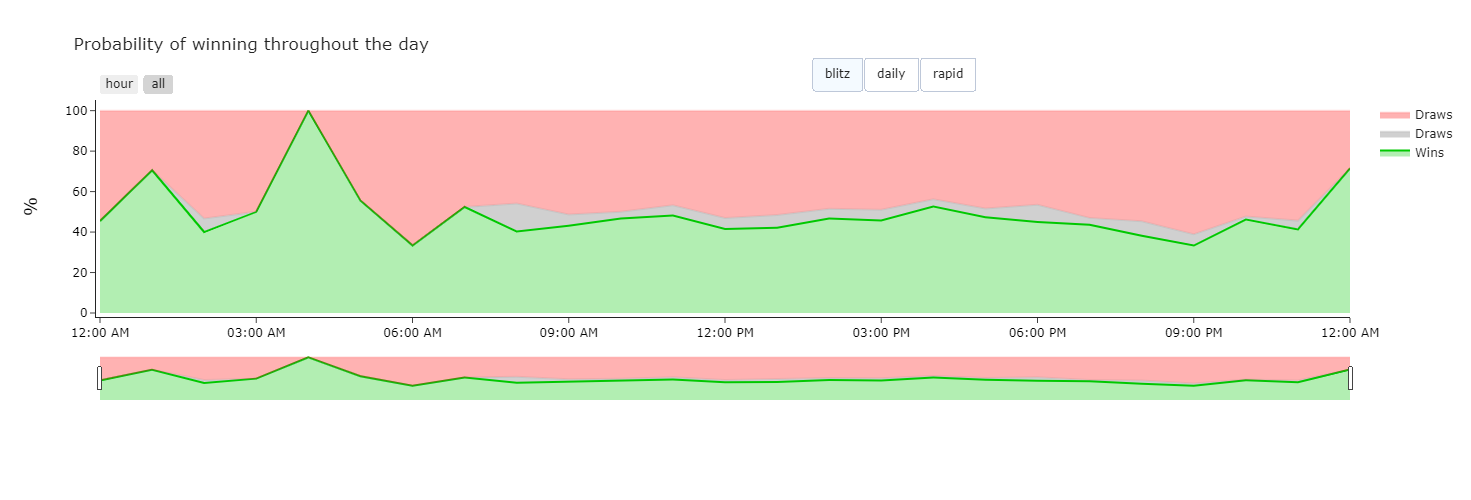

In [143]:
# Plot data
fig = go.Figure()

colors = ["rgba(0, 200, 0, %s)", "rgba(100, 100, 100, %s)", "rgba(255, 0, 0, %s)"]
button_list = []

for gg, game_type in enumerate(game_types.unique()):

    games = daily_games[(daily_games["time_class"]==game_type)]
    
    total_games = games[[f"{window}_mins", "count"]].groupby([f"{window}_mins"]).sum().reset_index()
    
    # Only consider bins with at least 5 games played, so not to skew the percentages
    game_wins = games[(games["result"]=="win")&(games["count"]>=1)]
    game_wins = game_wins.rename(columns={"count": "count_results"})

    game_wins = game_wins.merge(total_games, on=f"{window}_mins", how='inner')

    fig.add_trace(go.Scatter(
        x=game_wins[f"{window}_mins"], 
        y=game_wins[f"count_results"]/game_wins[f"count"]*100, 
        name="Wins",
        line={"color": "rgba(0, 200, 0, 1)"},
        fill='tozeroy',
        fillcolor="rgba(0, 200, 0, 0.3)",
        visible=True if gg==0 else False
        ),
    )
    
    date_master = game_wins[[f"{window}_mins"]]
    
    game_draws = games[(games["result"]=="draw")&(games["count"]>=1)]
    game_draws = game_draws.rename(columns={"count": "count_results"})
    
    game_draws = date_master.merge(game_draws, on=f"{window}_mins", how="left")
    game_draws = game_draws.fillna(0)

    game_draws = game_draws.merge(total_games, on=f"{window}_mins", how='inner')

    fig.add_trace(go.Scatter(
        x=game_draws[f"{window}_mins"], 
        y=game_draws[f"count_results"]/game_draws[f"count"]*100 + game_wins[f"count_results"]/game_wins[f"count"]*100, 
        name="Draws",
        line={"color": "rgba(100, 100, 100, 0.1)"},
        fill='tonexty',
        fillcolor="rgba(100, 100, 100, 0.3)",
        visible=True if gg==0 else False
        ),
    )
    
    game_losses = games[(games["result"]=="loss")&(games["count"]>=1)]
    game_losses = game_losses.rename(columns={"count": "count_results"})
    
    game_losses = date_master.merge(game_losses, on=f"{window}_mins", how="left")
    game_losses = game_losses.fillna(0)

    game_losses = game_losses.merge(total_games, on=f"{window}_mins", how='inner')
    
    fig.add_trace(go.Scatter(
        x=game_losses[f"{window}_mins"], 
        y=game_draws[f"count_results"]/game_draws[f"count"]*100 + game_wins[f"count_results"]/game_wins[f"count"]*100 + game_losses[f"count_results"]/game_losses[f"count"]*100, 
        name="Draws",
        line={"color": "rgba(255, 0, 0, 0.1)"},
        fill='tonexty',
        fillcolor="rgba(255, 0, 0, 0.3)",
        visible=True if gg==0 else False
        ),
    )

    button = dict(
        label=game_type,
        method="update",
        args=[
            {"visible": [False]*gg*3 + [True]*3 + [False]*(len(game_types)-gg-1)*3},
        ],
    )
    button_list.append(button)

fig.update_layout(
    template="simple_white",
    title=f"Probability of winning throughout the day",
    xaxis_tickformat='%I:%M %p',
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=100,
        r=100,
        b=100,
        t=100,
        pad=4
    ),
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            x=0.7,
            y=1.2,
            showactive=True,
            buttons=button_list
        )
    ]
)

fig.update_yaxes(
    title="%",
    title_font=dict(size=18, color='black'), 
    tickfont=dict(color="black")
)

fig.update_xaxes(
    tickfont=dict(color="black"),
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="hour", step="hour", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.add_hline(y=0.9)

fig.show()

# Get opponent information

In [218]:
# user_stats = []

# for uu, username in enumerate(df["opponent"].unique()[:]):
    
#     r = requests.get(f"https://api.chess.com/pub/player/{username}")
#     user_stats.append(r.json())
    
#     if divmod(uu, 50)[1] == 0:
#         print(uu, r)

# user_info = pd.DataFrame(user_stats)
# user_info.to_json("data/opponents.json", orient="records")

user_info = pd.read_json("data/opponents.json")
user_info = user_info.dropna(subset=["country"])
user_info = user_info[["country", "username"]].rename(columns={"username": "opponent", "country": "@id"})

# country_info = []

# for country in user_info["country"].unique():
#     r = requests.get(country)
#     country_info.append(r.json())
    
# country_info = pd.DataFrame(country_info)

country_info = pd.read_json("data/countries.json")
country_info = country_info[["@id", "name"]].rename(columns={"name": "opponent_country"})

user_info = user_info[["opponent", "@id"]].merge(country_info, on="@id", how="inner")

In [219]:
user_info

,opponent,@id,opponent_country
0,radioactiverabbit,https://api.chess.com/pub/country/AU,Australia
1,sam-marsh,https://api.chess.com/pub/country/AU,Australia
2,carlostr7,https://api.chess.com/pub/country/AU,Australia
3,benji2992,https://api.chess.com/pub/country/AU,Australia
4,fairlyrudedude,https://api.chess.com/pub/country/AU,Australia
...,...,...,...
3630,theheartkid,https://api.chess.com/pub/country/BB,Barbados
3631,letlapa007,https://api.chess.com/pub/country/BW,Botswana
3632,will-inglis,https://api.chess.com/pub/country/XS,Scotland
3633,socialisticlycantrophy,https://api.chess.com/pub/country/TL,Timor-Leste


In [220]:
opponents = df.copy()
opponents["opponent"] = opponents["opponent"].str.lower()

opponents = opponents.merge(user_info, on="opponent", how="left")
opponents = opponents[["time_class", "result", "opponent_country", "rating"]]

In [222]:
opponents.groupby(["time_class", "opponent_country", "result"]).count().reset_index().sort_values(by=["opponent_country", "time_class", "result"])

,time_class,opponent_country,result,rating
0,blitz,Afghanistan,loss,2
1,blitz,Afghanistan,win,2
377,rapid,Afghanistan,loss,1
378,rapid,Afghanistan,win,2
2,blitz,Albania,loss,7
...,...,...,...,...
277,blitz,Zimbabwe,loss,1
278,blitz,Zimbabwe,win,1
376,daily,Zimbabwe,loss,1
598,rapid,Zimbabwe,loss,1


In [221]:
opponents

,time_class,result,opponent_country,rating
0,daily,win,Australia,1296
1,daily,win,Australia,1391
2,daily,win,Australia,1417
3,daily,win,Australia,1417
4,daily,loss,Australia,1200
...,...,...,...,...
4231,rapid,loss,Bahrain,1388
4232,rapid,loss,Mexico,1380
4233,rapid,win,Australia,1387
4234,rapid,loss,Belgium,1379
